## import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# GPU setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 3080


## load data

In [3]:
xy = pd.read_csv('../data/tr.csv')
xy = xy.interpolate()
xy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523 entries, 0 to 522
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   date                                   523 non-null    object 
 1   new_cases                              523 non-null    int64  
 2   total_cases                            523 non-null    int64  
 3   new_cases_smoothed                     523 non-null    float64
 4   total_deaths                           523 non-null    int64  
 5   new_deaths                             523 non-null    int64  
 6   new_deaths_smoothed                    523 non-null    float64
 7   total_cases_per_million                523 non-null    float64
 8   new_cases_per_million                  523 non-null    float64
 9   new_cases_smoothed_per_million         523 non-null    float64
 10  total_deaths_per_million               523 non-null    float64
 11  new_de

## hyper parameter

In [4]:
seq_length = 5                # 5 일치의 데이터 입력
input_dim = len(xy.iloc[0])-1 # feature 개수
hidden_dim = 5
output_dim = 1
learning_rate = 0.001
epoch = 300
train_size = int(len(xy) * 0.8)
num_layers = 1
num_classes = 1

## Scaling

In [5]:
scaler = MinMaxScaler()
origin_scale = xy.iloc[:, [1]].to_numpy()

# 입력변수를 MinMaxScaling 하기
xy.iloc[:,1:] = scaler.fit_transform(xy.iloc[:,1:])

In [6]:
# Training/Test ratio = 8:2
train_size = int(len(xy) * 0.8)
# Data Division
train_size = int(len(xy) * 0.8)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

## dataset function

In [7]:
def sliding_windows(time_series, seq_length, day):
    x = []
    y = []
    for i in range(len(time_series) - seq_length - day+1):
        _x = time_series.iloc[i:i+seq_length, 1:]
        _y = time_series.iloc[i+seq_length+day-1, [1]]
        # print(_x, '->', _y)
        x.append(_x)
        y.append(_y)
    return np.array(x), np.array(y, dtype = float)

## build dataset

In [8]:
trainX, trainY = sliding_windows(train_set, seq_length, 14)
testX, testY = sliding_windows(test_set, seq_length, 14)

### array -> tensor

In [9]:
trainX_tensor = torch.FloatTensor(trainX).to(device)
trainY_tensor = torch.FloatTensor(trainY).to(device)
testX_tensor = torch.FloatTensor(testX).to(device)
testY_tensor = torch.FloatTensor(testY).to(device)

# LSTM

In [10]:
# class LSTM(nn.Module):

#     def __init__(self, num_classes, input_size, hidden_size, num_layers):
#         super(LSTM, self).__init__()

#         self.num_classes = num_classes
#         self.num_layers = num_layers
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.seq_length = seq_length

#         self.lstm = nn.LSTM(
#             input_size=input_size,
#             hidden_size=hidden_size,
#             num_layers=num_layers,
#             batch_first=True
#             )
        
#         self.fc = nn.Linear(hidden_size, num_classes)
    
#     def forward(self, x):

#         h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
#         c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)

#         # Propagate input through LSTM
#         ula, (h_out, _) = self.lstm(x, (h_0, c_0))
#         h_out = h_out.view(-1, self.hidden_size).to(device)

#         out = self.fc(h_out)

#         return out

In [11]:
# lstm = LSTM(
#     num_classes=num_classes,
#     input_size=input_dim,
#     hidden_size=hidden_dim,
#     num_layers=num_layers).to(device)

# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# from tqdm import tqdm
# # Train the model
# # for i in 
# for epoch in tqdm(range(epoch)):
#     outputs = lstm(trainX_tensor)
#     optimizer.zero_grad()

#     # obtain the loss function
#     loss = criterion(outputs, trainY_tensor)
#     loss.backward()
#     optimizer.step()
# lstm.eval()

In [12]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [13]:
# Initialize model and optimizer
lstm = LSTM(input_dim, hidden_dim, output_dim, num_layers).to(device)
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)

from tqdm import tqdm
# Train model
for epoch in tqdm(range(epoch)):
    # Forward pass
    output = lstm(trainX_tensor)
    loss = nn.MSELoss()(output, trainY_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # # Print training progress
    # if (epoch+1) % 10 == 0:
    #     print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# Evaluate model on test set
lstm.eval()
with torch.no_grad():
    output = lstm(testX_tensor)
    test_loss = nn.MSELoss()(output, testY_tensor)
    print('Test Loss: {:.4f}'.format(test_loss.item()))


100%|██████████| 300/300 [00:00<00:00, 727.96it/s]

Test Loss: 0.0092


In [14]:
inverse_scaler = MinMaxScaler()
inverse_scaler = inverse_scaler.fit(origin_scale)

inverse_x = inverse_scaler.inverse_transform(lstm(testX_tensor).cpu().detach().numpy())
inverse_y = inverse_scaler.inverse_transform(testY)

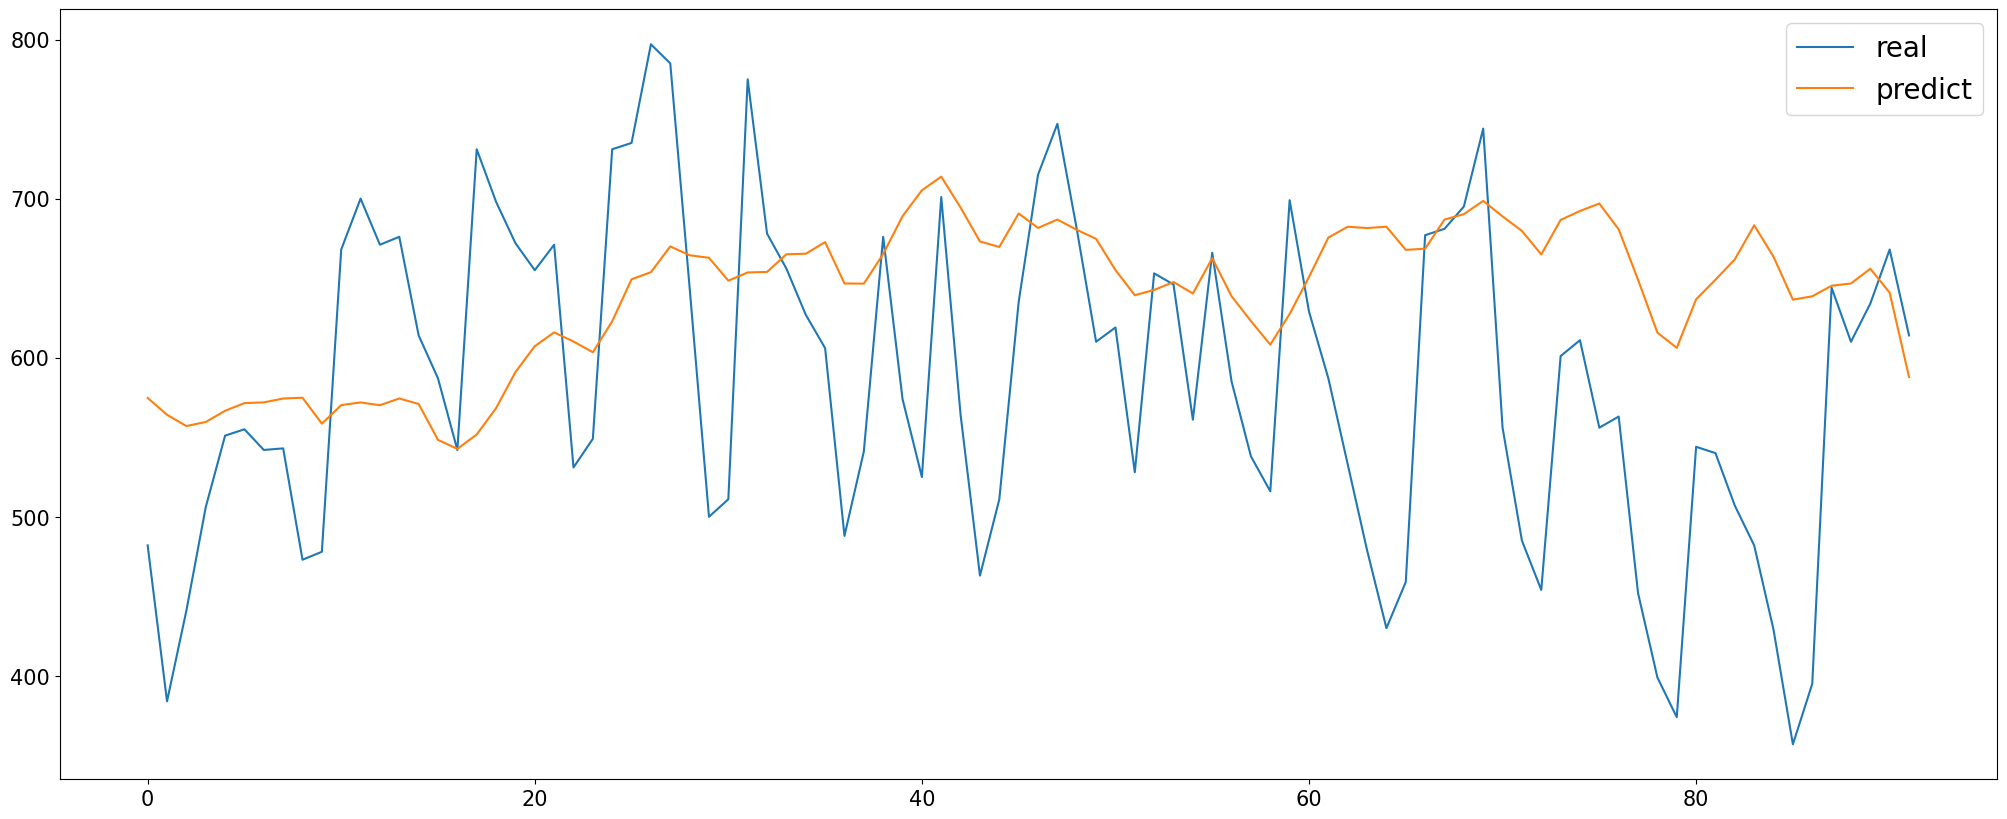

In [15]:
plt.rc('font', size=15)
plt.figure(figsize=(25,10))
plt.plot(inverse_y, label = 'real')
plt.plot(inverse_x, label = 'predict')
# plt.xlabel('테스트 셋 일자')
# plt.ylabel('확진자 수')
plt.rc('legend', fontsize = 20)
plt.legend()
plt.show()

# day 14

In [16]:
Date = xy.iloc[:,0]
date = Date.iloc[train_size+13:]

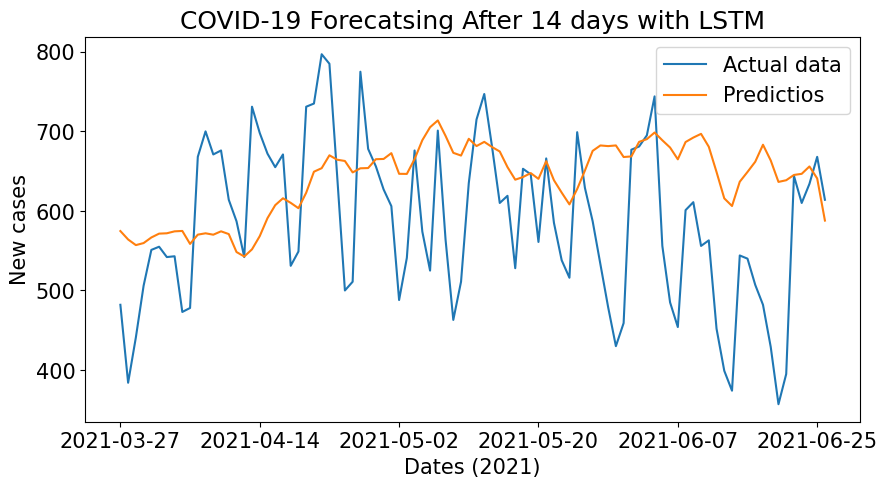

In [17]:
plt.rc('font', size=15)
plt.figure(figsize=(10,5))
plt.plot(inverse_y, label = 'Actual data')
plt.plot(date, inverse_x, label = 'Predictios')
plt.xticks(np.arange(0,len(inverse_y), 18))
plt.title('COVID-19 Forecatsing After 14 days with LSTM')
plt.xlabel('Dates (2021)')
plt.ylabel('New cases')
plt.rc('legend', fontsize = 15)
plt.legend()
plt.show()

In [18]:
def rmse(pred, real):
    E = pred-real
    SE = []
    for i in E:
        SE.append(i**2)
    MSE = sum(SE)/len(SE)
    RMSE = MSE**0.5
    return RMSE


rmse1 = rmse(inverse_x.flatten(), inverse_y.flatten())
print(rmse1)

118.40345629724173


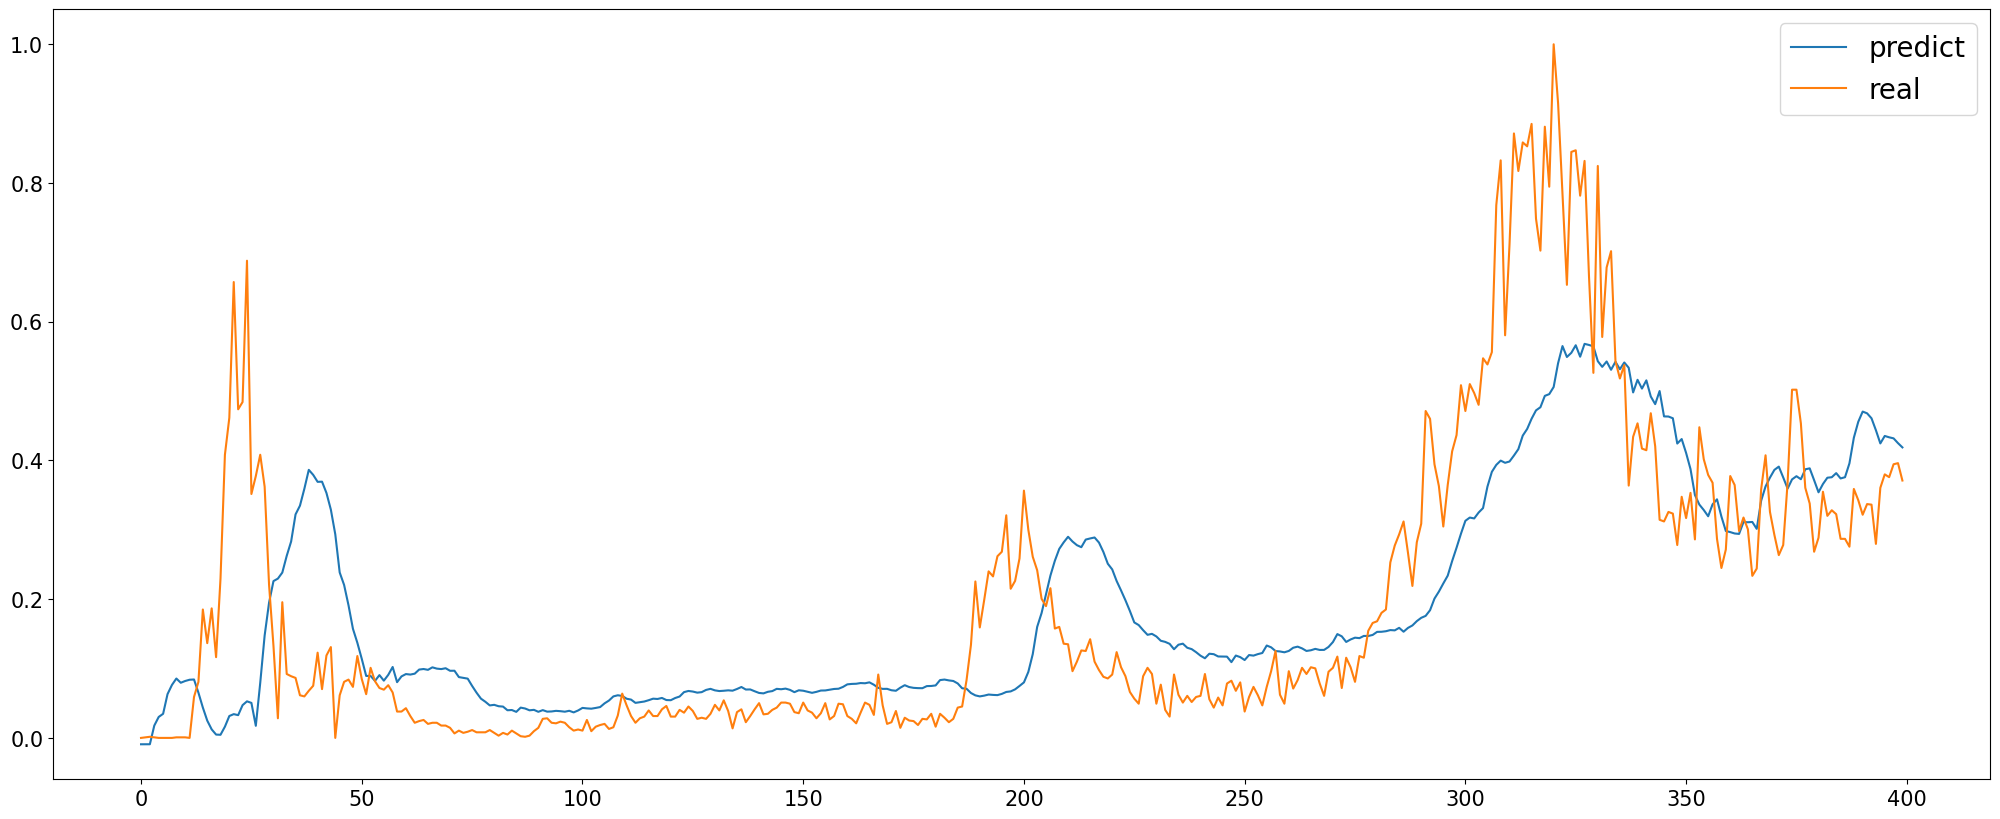

In [19]:
plt.rc('font', size=15)
plt.figure(figsize=(25,10))
plt.plot(lstm(trainX_tensor).cpu().detach().numpy(), label = 'predict')
plt.plot(trainY, label = 'real')
# plt.xlabel('테스트 셋 일자')
# plt.ylabel('확진자 수')
plt.rc('legend', fontsize = 20)
plt.legend()
plt.show()